<a href="https://colab.research.google.com/github/AdilsonFilho23/Trabalho-Big-data/blob/main/Trabalho_big_data_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn import tree
import dash
from dash.dependencies import Input, Output
import dash_core_components as dcc
import dash_html_components as html

In [ ]:
# Carregando os dados
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# --- Engenharia de Recursos ---
# Criando um novo recurso 'FamilySize'
for dataset in [train_data, test_data]:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Criando um novo recurso 'IsAlone'
for dataset in [train_data, test_data]:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

In [ ]:
# --- Pré-processamento ---
# Separando features e target no conjunto de treino
X_train = train_data.drop('Survived', axis=1)
y_train = train_data['Survived']

# Features para o conjunto de teste
X_test = test_data

# Definindo colunas numéricas e categóricas
numerical_features = ['Age', 'Fare', 'FamilySize'] # Incluindo FamilySize
categorical_features = ['Pclass', 'Sex', 'Embarked', 'IsAlone'] # Incluindo IsAlone

# Criando pipelines para pré-processamento
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
])

# Combinando pipelines usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features),
    ])

# Aplicando o pré-processamento aos dados de treino e teste
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [ ]:
# --- Treinamento e Avaliação ---
# Definindo os modelos com GridSearchCV e KFold
models = {
    'Decision Tree': GridSearchCV(DecisionTreeClassifier(), param_grid={'max_depth': [3, 5, 7]}, cv=KFold(n_splits=5)),
    'KNN': GridSearchCV(KNeighborsClassifier(), param_grid={'n_neighbors': [3, 5, 7]}, cv=KFold(n_splits=5)),
    'Logistic Regression': GridSearchCV(LogisticRegression(), param_grid={'C': [0.1, 1, 10]}, cv=KFold(n_splits=5)),
}

# Treinando e avaliando os modelos
for model_name, model in models.items():
    model.fit(X_train, y_train)

    # Fazendo previsões no conjunto de teste
    y_pred = model.predict(X_test)

    # Carregando o arquivo gender_submission para obter os IDs dos passageiros
    gender_submission = pd.read_csv('gender_submission.csv')

    # Criando um DataFrame com os IDs e as previsões
    submission = pd.DataFrame({'PassengerId': gender_submission['PassengerId'], 'Survived': y_pred})

    # Salvando as previsões em um arquivo CSV
    submission.to_csv(f'{model_name}_submission.csv', index=False)

    print(f"Previsões para {model_name} salvas em {model_name}_submission.csv")

Previsões para Decision Tree salvas em Decision Tree_submission.csv
Previsões para KNN salvas em KNN_submission.csv
Previsões para Logistic Regression salvas em Logistic Regression_submission.csv


In [ ]:
treino = pd.read_csv('train.csv')
treino.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [ ]:
teste = pd.read_csv('test.csv')
teste.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [ ]:
# Eliminando as colunas com elevada cardinalidade
treino = treino.drop(['Name','Ticket','Cabin'],axis=1)
teste = teste.drop(['Name','Ticket','Cabin'],axis=1)

In [ ]:
# Usando a média para substituir valores nulos na coluna de idade
treino.loc[treino.Age.isnull(),'Age'] = treino.Age.mean()
teste.loc[teste.Age.isnull(),'Age'] = teste.Age.mean()

In [ ]:
# Tratando a coluna Embarked da base de treino usando a moda
treino.loc[treino.Embarked.isnull(),'Embarked'] = treino.Embarked.mode()[0]

In [ ]:
# Tratando a coluna Fare da base de teste usando a média
teste.loc[teste.Fare.isnull(),'Fare'] = teste.Fare.mean()

In [ ]:
# Usando uma lambda function para tratar a coluna "Sex"
treino['MaleCheck'] = treino.Sex.apply(lambda x: 1 if x == 'male' else 0)
teste['MaleCheck'] = teste.Sex.apply(lambda x: 1 if x == 'male' else 0)

In [ ]:
# Fit com os dados
ohe = OneHotEncoder(handle_unknown='ignore',dtype='int32')
ohe = ohe.fit(treino[['Embarked']])

In [ ]:
# Atualizando a base de treino com os novos valores
ohe_df = pd.DataFrame(ohe.transform(treino[['Embarked']]).toarray(),columns=ohe.get_feature_names_out())
treino = pd.concat([treino,ohe_df],axis=1)

In [ ]:
# Atualizando a base de teste
ohe_df = pd.DataFrame(ohe.transform(teste[['Embarked']]).toarray(),columns=ohe.get_feature_names_out())
teste = pd.concat([teste,ohe_df],axis=1)

In [ ]:
# Apagar as colunas tratadas
treino = treino.drop(['Sex','Embarked'],axis=1)
teste = teste.drop(['Sex','Embarked'],axis=1)

In [ ]:
# Visualizando a base de treino
treino.head(3)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,MaleCheck,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,1,0,0,1
1,2,1,1,38.0,1,0,71.2833,0,1,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,0,1


In [ ]:
# Criando o scaler
transformer = RobustScaler().fit(treino[['Age','Fare']])

In [ ]:
# Fazendo o transformação dos dados
treino[['Age','Fare']] = transformer.transform(treino[['Age','Fare']])

In [ ]:
# Fazendo o mesmo para a base de teste
transformer = RobustScaler().fit(teste[['Age','Fare']])
teste[['Age','Fare']] = transformer.transform(teste[['Age','Fare']])

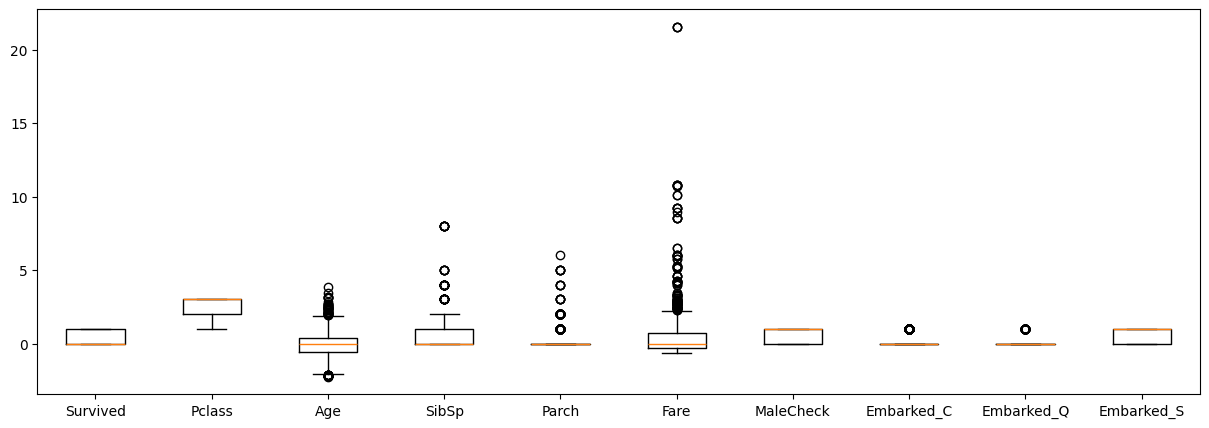

In [ ]:
# Visualizando novamente os dados
fig, ax = plt.subplots(figsize=(15,5))

ax.boxplot(treino.iloc[:,1:11])
ax.set_xticks(range(1,treino.iloc[:,1:11].shape[1]+1),treino.iloc[:,1:11].columns)

plt.show()

In [ ]:
# Verificando a sobrevivência para SibSp
SibSp_df = treino.groupby('SibSp')['Survived'].agg(['sum','count','mean']).reset_index()
SibSp_df.columns = ['SibSp','sobrev','total','tx_sobrev']
SibSp_df

,SibSp,sobrev,total,tx_sobrev
0,0,210,608,0.345395
1,1,112,209,0.535885
2,2,13,28,0.464286
3,3,4,16,0.250000
4,4,3,18,0.166667
5,5,0,5,0.000000
6,8,0,7,0.000000


In [ ]:
# Verificando a sobrevivência para Parch
Parch_df = treino.groupby('Parch')['Survived'].agg(['sum','count','mean']).reset_index()
Parch_df.columns = ['Parch','sobrev','total','tx_sobrev']
Parch_df

,Parch,sobrev,total,tx_sobrev
0,0,233,678,0.343658
1,1,65,118,0.550847
2,2,40,80,0.500000
3,3,3,5,0.600000
4,4,0,4,0.000000
5,5,1,5,0.200000
6,6,0,1,0.000000


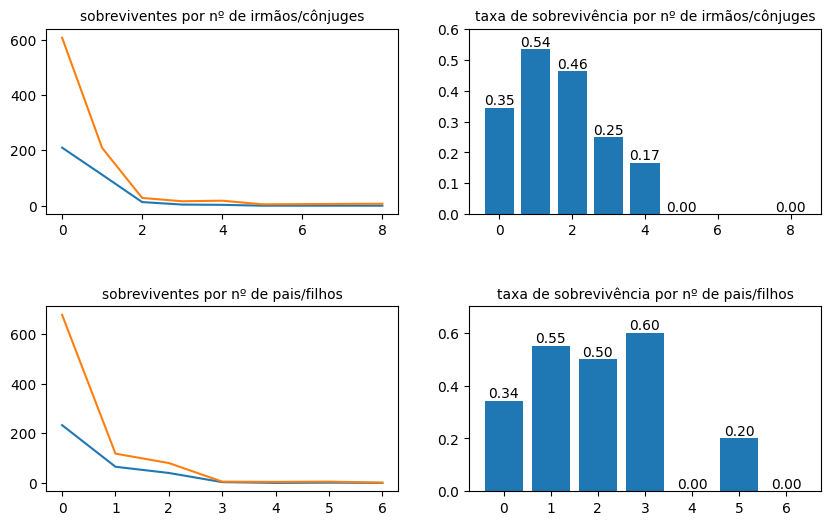

In [ ]:
# Visualizando essas informações graficamente
fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(10,6))

ax[0,0].plot(SibSp_df.SibSp, SibSp_df.sobrev)
ax[0,0].plot(SibSp_df.SibSp, SibSp_df.total)
ax[0,0].set_title('sobreviventes por nº de irmãos/cônjuges', fontsize=10)

labels1 = ax[0,1].bar(SibSp_df.SibSp, SibSp_df.tx_sobrev)
ax[0,1].bar_label(labels1,fmt="%.02f")
ax[0,1].set(ylim=(0,0.6))
ax[0,1].set_title('taxa de sobrevivência por nº de irmãos/cônjuges', fontsize=10)

ax[1,0].plot(Parch_df.Parch, Parch_df.sobrev)
ax[1,0].plot(Parch_df.Parch, Parch_df.total)
ax[1,0].set_title('sobreviventes por nº de pais/filhos', fontsize=10)

labels2 = ax[1,1].bar(Parch_df.Parch, Parch_df.tx_sobrev)
ax[1,1].bar_label(labels2,fmt="%.02f")
ax[1,1].set(ylim=(0,0.7))
ax[1,1].set_title('taxa de sobrevivência por nº de pais/filhos', fontsize=10)

plt.subplots_adjust(hspace=0.5)

plt.show()

In [ ]:
# Criando uma função para verificar se os dois valores são vazios
def sozinho(a,b):
    if (a == 0 and b == 0):
        return 1
    else:
        return 0

In [ ]:
# Aplicando essa função na base de treino
treino['Sozinho'] = treino.apply(lambda x: sozinho(x.SibSp,x.Parch),axis=1)

In [ ]:
# Verificando os valores nessa coluna
treino.groupby('Sozinho')[['SibSp','Parch']].mean()

,SibSp,Parch
Sozinho,,
0,1.316384,0.960452
1,0.000000,0.000000


In [ ]:
# Fazendo o mesmo para a base de teste
teste['Sozinho'] = teste.apply(lambda x: sozinho(x.SibSp,x.Parch),axis=1)

In [ ]:
# Criando para a base de treino
treino['Familiares'] = treino.SibSp + treino.Parch

In [ ]:
# E para a base de teste
teste['Familiares'] = treino.SibSp + treino.Parch

In [ ]:
# Verificando a sobrevivência para Familiares
Familiares_df = treino.groupby('Familiares')['Survived'].agg(['sum','count','mean']).reset_index()
Familiares_df.columns = ['Familiares','sobrev','total','tx_sobrev']
Familiares_df

,Familiares,sobrev,total,tx_sobrev
0,0,163,537,0.303538
1,1,89,161,0.552795
2,2,59,102,0.578431
3,3,21,29,0.724138
4,4,3,15,0.200000
5,5,3,22,0.136364
6,6,4,12,0.333333
7,7,0,6,0.000000
8,10,0,7,0.000000


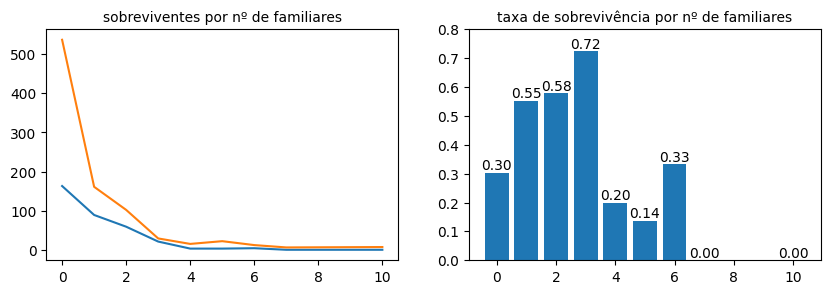

In [ ]:
# Visualizando a informação de familiares
fig, ax = plt.subplots(ncols=2,figsize=(10,3))

ax[0].plot(Familiares_df.Familiares, Familiares_df.sobrev)
ax[0].plot(Familiares_df.Familiares, Familiares_df.total)
ax[0].set_title('sobreviventes por nº de familiares', fontsize=10)

labels1 = ax[1].bar(Familiares_df.Familiares, Familiares_df.tx_sobrev)
ax[1].bar_label(labels1,fmt="%.02f")
ax[1].set(ylim=(0,0.8))
ax[1].set_title('taxa de sobrevivência por nº de familiares', fontsize=10)

plt.show()

In [ ]:
# Visualizando a base
treino.head(3)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,MaleCheck,Embarked_C,Embarked_Q,Embarked_S,Sozinho,Familiares
0,1,0,3,-0.592240,1,0,-0.312011,1,0,0,1,0,1
1,2,1,1,0.638529,1,0,2.461242,0,1,0,0,0,1
2,3,1,3,-0.284548,0,0,-0.282777,0,0,0,1,1,0


In [ ]:
# Analisando a correlação entre as variáveis
treino.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,MaleCheck,Embarked_C,Embarked_Q,Embarked_S,Sozinho,Familiares
PassengerId,1.000000,-0.005007,-0.035144,0.033207,-0.057527,-0.001652,0.012658,0.042939,-0.001205,-0.033606,0.022204,0.057462,-0.040143
Survived,-0.005007,1.000000,-0.338481,-0.069809,-0.035322,0.081629,0.257307,-0.543351,0.168240,0.003650,-0.149683,-0.203367,0.016639
Pclass,-0.035144,-0.338481,1.000000,-0.331339,0.083081,0.018443,-0.549500,0.131900,-0.243292,0.221009,0.074053,0.135207,0.065997
Age,0.033207,-0.069809,-0.331339,1.000000,-0.232625,-0.179191,0.091566,0.084153,0.032024,-0.013855,-0.019336,0.179775,-0.248512
SibSp,-0.057527,-0.035322,0.083081,-0.232625,1.000000,0.414838,0.159651,-0.114631,-0.059528,-0.026354,0.068734,-0.584471,0.890712
Parch,-0.001652,0.081629,0.018443,-0.179191,0.414838,1.000000,0.216225,-0.245489,-0.011069,-0.081228,0.060814,-0.583398,0.783111
Fare,0.012658,0.257307,-0.549500,0.091566,0.159651,0.216225,1.000000,-0.182333,0.269335,-0.117216,-0.162184,-0.271832,0.217138
MaleCheck,0.042939,-0.543351,0.131900,0.084153,-0.114631,-0.245489,-0.182333,1.000000,-0.082853,-0.074115,0.119224,0.303646,-0.200988
Embarked_C,-0.001205,0.168240,-0.243292,0.032024,-0.059528,-0.011069,0.269335,-0.082853,1.000000,-0.148258,-0.782742,-0.095298,-0.046215
Embarked_Q,-0.033606,0.003650,0.221009,-0.013855,-0.026354,-0.081228,-0.117216,-0.074115,-0.148258,1.000000,-0.499421,0.086464,-0.058592


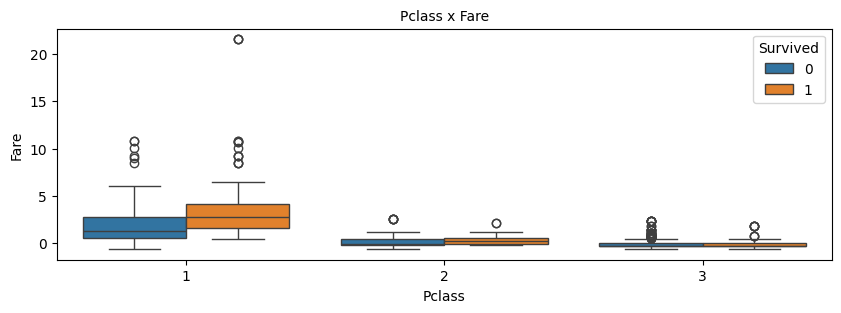

In [ ]:
# Visualizando a relação entre essas variáveis
fig, ax = plt.subplots(figsize=(10,3))

sns.boxplot(data=treino,x='Pclass',y='Fare',hue='Survived')
ax.set_title('Pclass x Fare', fontsize=10)

plt.show()

In [ ]:
# Verificando a taxa de sobrevivência em cada uma das classes
treino.groupby('Pclass')['Survived'].mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [ ]:
# Entendendo a relação entre Pclass x Fare
treino.groupby(['Pclass','Survived'])['Fare'].agg(['min','mean','max'])

min      mean        max
Pclass Survived                               
1      0        -0.626005  2.175430  10.764405
       1         0.496977  3.514735  21.562738
2      0        -0.626005  0.214734   2.557247
       1        -0.171255  0.329217   2.189115
3      0        -0.626005 -0.033991   2.386174
       1        -0.626005 -0.032885   1.820802

In [ ]:
# "Recuperar" a coluna de embarque
treino2 = pd.read_csv('train.csv')
teste2 = pd.read_csv('test.csv')

treino2.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [ ]:
# Tratamento dos dados de dados vazios
treino2['Embarked'] = treino2['Embarked'].fillna('S')

In [ ]:
# Criando o encoder
categorias = ['S','C','Q']

enc = OrdinalEncoder(categories=[categorias],dtype='int32')

In [ ]:
# Fit com os dados
enc = enc.fit(treino2[['Embarked']])

In [ ]:
# Adicionar a coluna na base de treino original
treino['Embarked'] = enc.transform(treino2[['Embarked']])

In [ ]:
# Fit com os dados de teste
enc = enc.fit(teste2[['Embarked']])

In [ ]:
# Adicionar na base de teste original
teste['Embarked'] = enc.transform(teste2[['Embarked']])

In [ ]:
# Eliminar as colunas desnecessárias
treino = treino.drop(['Embarked_C','Embarked_Q','Embarked_S'],axis=1)
teste = teste.drop(['Embarked_C','Embarked_Q','Embarked_S'],axis=1)

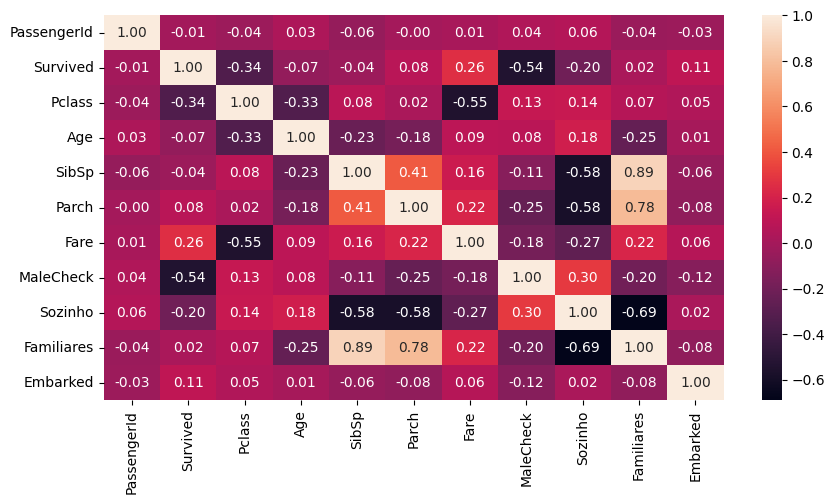

In [ ]:
# Visualizando a correlação
fig, ax = plt.subplots(figsize=(10,5))

sns.heatmap(treino.corr(), annot=True, fmt=".2f")

plt.show()

In [ ]:
# Separando a base de treino em X e y
X = treino.drop(['PassengerId','Survived'],axis=1)
y = treino.Survived

In [ ]:
# Separando em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# Criando o classificador da árvore de classificação
clf_ac = tree.DecisionTreeClassifier(random_state=42)

In [ ]:
# Fit com os dados
clf_ac = clf_ac.fit(X_train,y_train)

In [ ]:
# Previsão
y_pred_ac = clf_ac.predict(X_val)

In [ ]:
# Criando o classificador do K-Nearest Neighbors
clf_knn = KNeighborsClassifier(n_neighbors=3)

In [ ]:
# Fit com os dados
clf_knn = clf_knn.fit(X_train,y_train)

In [ ]:
# Previsão
y_pred_knn = clf_knn.predict(X_val)

In [ ]:
# Criando o classificador da regressão logística
clf_rl = LogisticRegression(random_state=42,max_iter=1000)

In [ ]:
# Fit com os dados
clf_rl = clf_rl.fit(X_train,y_train)

In [ ]:
# Previsão
y_pred_rl = clf_rl.predict(X_val)

In [ ]:
# Separando X e y
X = treino.drop(['PassengerId','Survived'],axis=1)
y = treino.Survived

In [ ]:
# Usando a regressão logística nos dados
clf_rl = LogisticRegression(random_state=42,max_iter=1000).fit(X,y)

In [ ]:
# Verificando a importância
clf_rl.coef_[0]

array([-1.03263042, -0.49652852, -0.26762379,  0.0163412 ,  0.04436238,
       -2.53517931, -0.73082523, -0.25128259,  0.23859331])

In [ ]:
# Usando a árvore de classificação
clf_ac = tree.DecisionTreeClassifier(random_state=42).fit(X,y)

In [ ]:
# Verificando a importância
clf_ac.feature_importances_

array([0.10901775, 0.22826711, 0.01907221, 0.0272942 , 0.23870173,
       0.30933519, 0.00397775, 0.04365035, 0.02068372])

In [ ]:
# Criando um DataFrame
imp = pd.DataFrame({
    'colunas': X.columns,
    'reg. log.': clf_rl.coef_[0],
    'arvore': clf_ac.feature_importances_
})

imp

,colunas,reg. log.,arvore
0,Pclass,-1.032630,0.109018
1,Age,-0.496529,0.228267
2,SibSp,-0.267624,0.019072
3,Parch,0.016341,0.027294
4,Fare,0.044362,0.238702
5,MaleCheck,-2.535179,0.309335
6,Sozinho,-0.730825,0.003978
7,Familiares,-0.251283,0.043650
8,Embarked,0.238593,0.020684


In [ ]:
# Manter as colunas mais relevantes
treino = treino.drop(['SibSp','Parch'],axis=1)
teste = teste.drop(['SibSp','Parch'],axis=1)

In [ ]:
treino.head(3)

,PassengerId,Survived,Pclass,Age,Fare,MaleCheck,Sozinho,Familiares,Embarked
0,1,0,3,-0.592240,-0.312011,1,0,1,0
1,2,1,1,0.638529,2.461242,0,0,1,1
2,3,1,3,-0.284548,-0.282777,0,1,0,0


In [ ]:
# Score para a árvore
as_ac = accuracy_score(y_val, y_pred_ac)
as_ac

0.7559322033898305

In [ ]:
# Score para o knn
as_knn = accuracy_score(y_val, y_pred_knn)
as_knn

0.7830508474576271

In [ ]:
# Score para a regressão logística
as_rl = accuracy_score(y_val, y_pred_rl)
as_rl

0.8067796610169492

In [ ]:
# Para a árvore de classificação
confusion_matrix(y_val, y_pred_ac)

array([[141,  34],
       [ 38,  82]])

In [ ]:
# Para o knn
confusion_matrix(y_val, y_pred_knn)

array([[151,  24],
       [ 40,  80]])

In [ ]:
# Para a regressão logística
confusion_matrix(y_val, y_pred_rl)

array([[152,  23],
       [ 34,  86]])

In [ ]:
# Para a base de teste ser igual a base de treino, precisamos eliminar a coluna de id
X_teste = teste.drop('PassengerId',axis=1)

In [ ]:
training_features = X_train.columns

# Verificar se as colunas em training_features estão presentes em X_teste
missing_cols = set(training_features) - set(X_teste.columns)

# Se houver colunas faltando, adicioná-las a X_teste com valor 0
for col in missing_cols:
    X_teste[col] = 0

# Garantir que estejam na mesma coluna que X_train
X_teste = X_teste[training_features]

# Utilizar a lógica de regressão no teste
y_pred_rl = clf_rl.predict(X_teste)

In [ ]:
# Criando uma nova coluna com a previsão na base de teste
teste['Survived'] = y_pred_rl

In [ ]:
# Selecionando as coluna para fazer o envio
base_envio = teste[['PassengerId','Survived', 'Pclass', 'Sozinho', 'Familiares', 'MaleCheck']]

In [ ]:
# Exportando para um csv
base_envio.to_csv('resultados_escala.csv',index=False)

In [ ]:
# Carregar os dados
df = pd.read_csv('resultados_escala.csv')

fig1 = px.histogram(df, x="Pclass", color="Survived", title="Sobrevivência por Classe")

app = dash.Dash(__name__)

# Layout do aplicativo
app.layout = html.Div([
    html.H1("Análise de sobreviventes por classe e gênero da tragédia titanic"),
    dcc.Graph(id='graph1', figure=fig1),
])

if __name__ == '__main__':
    app.run_server(debug=True)

    app.layout = html.Div([
    html.H1("Análise de sobreviventes por classe e gênero da tragédia titanic"),
    dcc.Dropdown(
        id='class-dropdown',
        options=[{'label': i, 'value': i} for i in df['Pclass'].unique()],
        value=1
    ),
    dcc.Graph(id='graph1'),
])

@app.callback(
    Output('graph1', 'figure'),
    [Input('class-dropdown', 'value')]
)
def update_graph(selected_class):
    filtered_df = df[df['Pclass'] == selected_class]
    fig = px.histogram(filtered_df, x="Survived", title=f"Sobreviventes de {selected_class}ª Classe")
    return fig

<IPython.core.display.Javascript object>